In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
import matplotlib.pyplot as plt
import yfinance as yf
import sys
from pyvalet import ValetInterpreter

print("Num GPUs Available: ",len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [13]:
# Parameters
STOCKS = ["CM.TO","RY.TO","BMO.TO","TD.TO","BNS.TO","EQB.TO","NA.TO","POW.TO"]  # List of stock symbols to train on
PREDICTION_DAYS = 60  # Number of days of historical data to use as input
PREDICTION_DAYS_AHEAD = 5  # Number of days to predict in advance
EPOCHS = 80  # Number of training epochs
BATCH_SIZE = 32  # Batch size for training
TRAIN_SPLIT = 0.8  # Split ratio for training data
STOCK_FOR_VALIDATION = "CM.TO"  # Stock to use for validation plot
MOVING_AVERAGE = 30 #Minimum value of 1
LSTM_UNITS = 150 * len(STOCKS) #How big brain the model is

START_DATE = "2014-01-01"
END_DATE = "2019-01-30"
FULL_DATE_RANGE = pd.date_range(start=START_DATE, end=END_DATE)

In [14]:
# Function to load stock data from Yahoo Finance
def load_data(stock_symbol):
    data = yf.download(stock_symbol, start=START_DATE, end=END_DATE)
    #print(data)
    return data['Close'].values  # Use closing price

#Function to load dividend data for a stock
def load_dividends(stock_symbol):
    ticker = yf.Ticker(stock_symbol)
    historical_data = ticker.history(start=START_DATE, end=END_DATE) 
    #print(historical_data['Dividends'].values)
    #Putting each element in its own array to be compatable with moving average computation
    dividend_in_arrays = []
    for value in historical_data['Dividends'].values:
        dividend_in_arrays.append([value])
    return dividend_in_arrays

#Function to load in policy rate
def load_policy_rate():
    ticker = yf.Ticker("CM.TO")
    historical_data = ticker.history(start=START_DATE, end=END_DATE)
    date_range = historical_data['Dividends'].axes[0].date
    boc = ValetInterpreter()
    policy_rates = boc.get_series_observations('V39079', start_date=START_DATE, end_date=END_DATE, response_format='csv')
    policy_rates['date'] = pd.to_datetime(policy_rates['date'])
    policy_rates = policy_rates[policy_rates['date'].isin(date_range)]
    policy_rates_in_arrays = [[float(rate)] for rate in policy_rates['V39079'].values]
    return policy_rates_in_arrays

#Function to load in CAD-USD exchange rate
def load_exchange_rate():
    symbol = "RY.TO"
    ticker = yf.Ticker(symbol)
    historical_data = ticker.history(start=START_DATE, end=END_DATE)
    dividend_data = historical_data['Dividends']
    dividend_data =pd.DataFrame({"Date": pd.DatetimeIndex(dividend_data.axes[0].date), "value": dividend_data.values}) 
    ticker = yf.Ticker("CAD=X")
    historical_data = ticker.history(start=START_DATE, end=END_DATE)
    USD_CAD_exhcange_rate = historical_data['Close']
    USD_CAD_exhcange_rate =pd.DataFrame({"Date": pd.DatetimeIndex(USD_CAD_exhcange_rate.axes[0].date), "value": USD_CAD_exhcange_rate.values})
    USD_CAD_exhcange_rate = USD_CAD_exhcange_rate[USD_CAD_exhcange_rate['Date'].isin(dividend_data['Date'])]
    date_list = np.union1d(USD_CAD_exhcange_rate['Date'].values, dividend_data['Date'].values)
    date_list_df = pd.DataFrame({"Date": pd.to_datetime(date_list)})
    USD_CAD_exhcange_rate = pd.merge(date_list_df,USD_CAD_exhcange_rate, on="Date",how="left")
    USD_CAD_exhcange_rate['value'] = USD_CAD_exhcange_rate['value'].ffill()
    USD_CAD_exhcange_rate_in_array = [[float(rate)] for rate in USD_CAD_exhcange_rate['value'].values]
    return USD_CAD_exhcange_rate_in_array

# Function to normalize data using min-max scaling with numpy
def normalize_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data, min_val, max_val

# Function to denormalize data
def denormalize_data(data, min_val, max_val):
    return data * (max_val - min_val) + min_val

# Calculate moving average (no change in array length)
def moving_average(data, window=MOVING_AVERAGE):
    averaged_data = []
    moving_total = 0
    denom = 0
    for i in range(len(data)):
        moving_total += data[i]
        denom += 1
        if(i > window):
            moving_total -= data[i-window]
            denom -= 1
        averaged_data.append(moving_total/denom)
    return averaged_data

# Function to preprocess data with moving average and variable prediction days
def preprocess_data(stock_data, stock_id):
    if(PREDICTION_DAYS > len(stock_data)):
        print("Error: PREDICTION_DAYS set to",PREDICTION_DAYS,"but stock_data is only",len(stock_data),"elements long")
        sys.exit(1)
    
    normalized_data, min_val, max_val = normalize_data(stock_data)
    
    x_train, y_train = [], []

    #removes first portion of data. Cannot predict when we don't have at least PREDICTION_DAYS + PREDICTION_DAYS_AHEAD of history.
    for i in range(PREDICTION_DAYS + PREDICTION_DAYS_AHEAD - 1, len(normalized_data)):
        x_train.append(normalized_data[i+1-(PREDICTION_DAYS + PREDICTION_DAYS_AHEAD):(i+1-PREDICTION_DAYS_AHEAD)]) #append an array of past values which will be input for LSTM model
        y_train.append(normalized_data[i]) #append the "answer" for correct y value
    
    return np.array(x_train), np.array(y_train), min_val, max_val

# Function to build the LSTM model with variable output days and 4 features in input
def build_model():
    model = Sequential()
    model.add(LSTM(units=LSTM_UNITS, return_sequences=True, input_shape=(PREDICTION_DAYS, len(STOCKS)))) 
    model.add(Dropout(0.2))
    model.add(LSTM(units=LSTM_UNITS, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer now predicts multiple days
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Define EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',   # Metric to monitor
    patience=10,          # Number of epochs with no improvement before stopping
    verbose=1,            # Display stopping message
    restore_best_weights=True  # Restore weights from the best epoch
)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/home/someone5853/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.3724 - val_loss: 0.0029
Epoch 2/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 3/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 4/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 8.6880e-04 - val_loss: 0.0011
Epoch 5/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 7.6254e-04 - val_loss: 0.0011
Epoch 6/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 6.4238e-04 - val_loss: 0.0011
Epoch 7/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 5.7167e-04 - val_loss: 0.0010
Epoch 8/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 5.9661e-04 - val_loss: 0.0011
Epoch 9/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 5.4635e-04 - val_loss: 0.0016
Epoch 10/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 5.1639e-04 - val_loss: 0.0016
Epoch 11/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 4.9021e-04 - val_loss: 0.0027
Epoch 12/80
31/31 ━━━━━━━━━━━━━

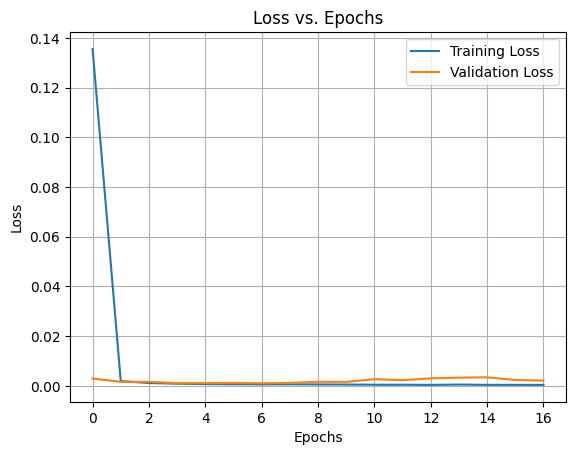

In [15]:
# Main execution: preprocess data for each stock and concatenate
all_x_data = []
selected_stock_x_data, selected_stock_y_data = [], []
selected_stock_min, selected_stock_max = 0, 0
for stock_id, stock in enumerate(STOCKS):
    stock_data = load_data(stock)
    # Apply moving average to smooth data
    stock_data_smoothed = moving_average(stock_data)
    x_train, y_train, min_val, max_val = preprocess_data(stock_data_smoothed, stock_id)
    if(stock == STOCK_FOR_VALIDATION):
        selected_stock_min, selected_stock_max = min_val, max_val
        selected_stock_x_data = x_train
        selected_stock_y_data = y_train
    all_x_data.append(x_train)
    
# Combine training data from all stocks
processed_x_data = np.concatenate(all_x_data, axis=2)
processed_y_data = np.concatenate(selected_stock_y_data)
processed_sel_x_data = np.concatenate(selected_stock_x_data)

# Split data into training and validation sets
split_index = int(TRAIN_SPLIT * len(processed_x_data))
all_x_train_data = processed_x_data[:split_index]
all_x_validation_data = processed_x_data[split_index:]
y_train_data = processed_y_data[:split_index]
y_validation_data = processed_y_data[split_index:]

# Build and train the model
model = build_model()
history = model.fit(all_x_train_data, y_train_data, validation_data=(all_x_validation_data, y_validation_data), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

# Make predictions on the training data
train_predictions = model.predict(all_x_train_data)
train_predicted_prices = denormalize_data(train_predictions, selected_stock_min, selected_stock_max)  # Convert predictions to original scale
train_real_prices = denormalize_data(y_train_data, selected_stock_min, selected_stock_max)

# Make predictions on the validation data
predictions = model.predict(all_x_validation_data)
predicted_prices = denormalize_data(predictions, selected_stock_min, selected_stock_max)  # Convert predictions to original scale
real_prices = denormalize_data(y_validation_data, selected_stock_min, selected_stock_max)

# Plot loss vs. epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%***********************]  1 of 1 completed


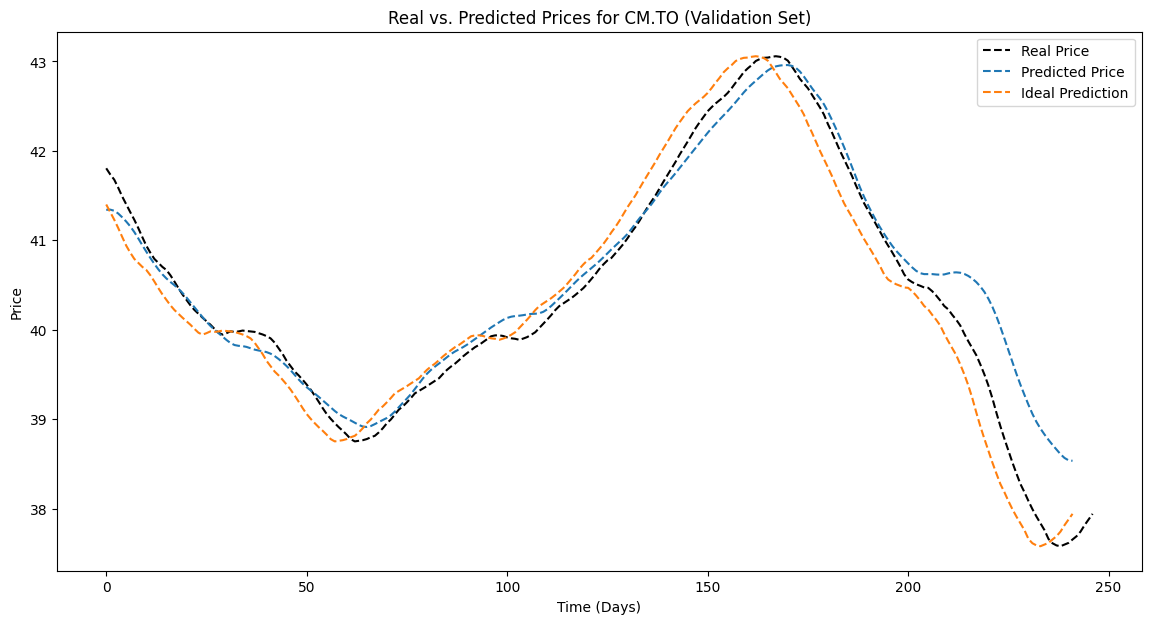

In [16]:
# Load real closing prices for the validation period
real_prices_data = yf.download(STOCK_FOR_VALIDATION, start=START_DATE, end=END_DATE)['Close'].values
real_prices_data = moving_average(real_prices_data)
real_prices_data = real_prices_data[PREDICTION_DAYS-1:]

real_prices_data_validation = real_prices_data[split_index:]  # Use only the validation portion
real_prices_data_training = real_prices_data[:split_index]  # Plot for training portion
# Plot the results for the validation portion
plt.figure(figsize=(14, 7))

# Plot the real prices directly
plt.plot(real_prices_data_validation, label='Real Price', color='black', linestyle='--')

# Plot predicted prices for each prediction day in the range of PREDICTION_DAYS_AHEAD

plt.plot(predicted_prices, label='Predicted Price ', linestyle='--')
plt.plot(real_prices, label='Ideal Prediction',linestyle='--')

plt.title(f"Real vs. Predicted Prices for {STOCK_FOR_VALIDATION} (Validation Set)")
plt.xlabel("Time (Days)")
plt.ylabel("Price")
plt.legend()
plt.show()

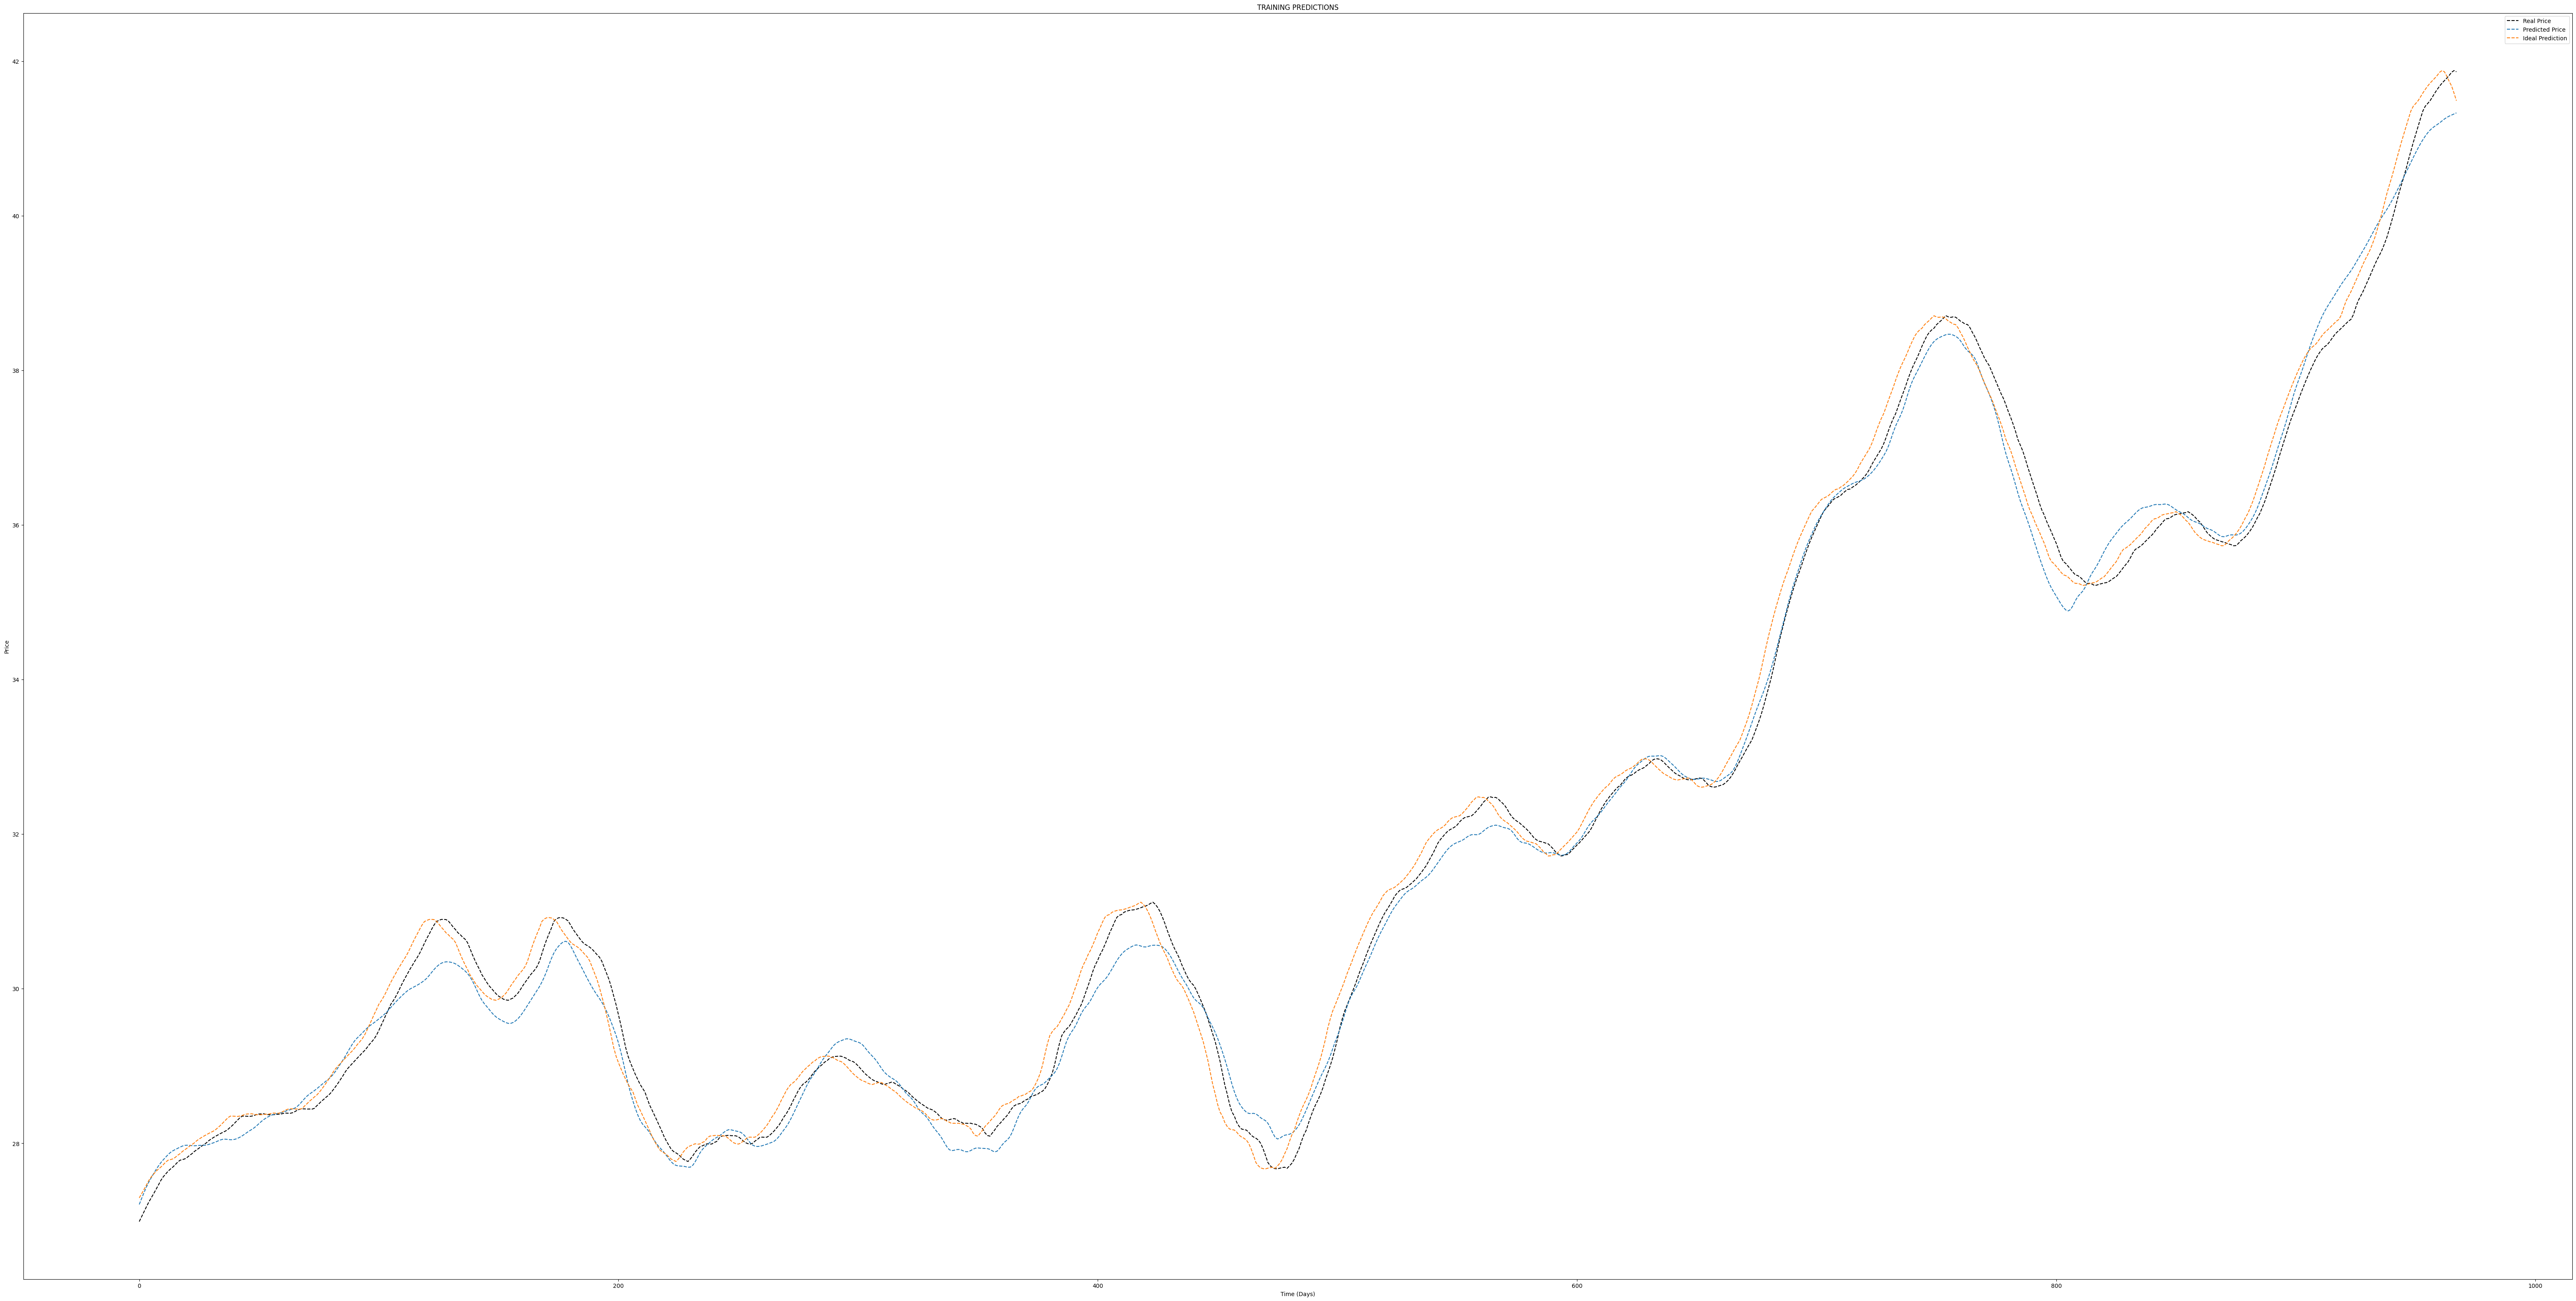

In [17]:
# Plot the results for the validation portion
plt.figure(figsize=(80, 40))

# Plot the real prices directly
plt.plot(real_prices_data_training, label='Real Price', color='black', linestyle='--')

# Plot predicted prices for each prediction day in the range of PREDICTION_DAYS_AHEAD

plt.plot(train_predicted_prices, label='Predicted Price', linestyle='--')
plt.plot(train_real_prices, label='Ideal Prediction',linestyle='--')

plt.title(f"TRAINING PREDICTIONS")
plt.xlabel("Time (Days)")
plt.ylabel("Price")
plt.legend()
#plt.xlim(2200, 2250)
plt.show()

In [18]:
#Traing data with other features
if True:
    for stock_id, stock in enumerate(STOCKS):
        dividend_data = load_dividends(stock)
        x_train, y_train, min_val, max_val = preprocess_data(dividend_data, stock_id)
        all_x_data.append(x_train)
if True:
    policy_rate = load_policy_rate()
    x_train, y_train, min_val, max_val = preprocess_data(policy_rate, stock_id)
    all_x_data.append(x_train)
if True:
    USD_CAD_exhcange_rate = load_exchange_rate()
    x_train, y_train, min_val, max_val = preprocess_data(USD_CAD_exhcange_rate, stock_id)
    all_x_data.append(x_train)

    
# Combine training data from all stocks
processed_x_data = []
processed_y_data = []
processed_sel_x_data = []
processed_x_data = np.concatenate(all_x_data, axis=2)
processed_y_data = np.concatenate(selected_stock_y_data)
processed_sel_x_data = np.concatenate(selected_stock_x_data)

# Split data into training and validation sets
split_index = int(TRAIN_SPLIT * len(processed_x_data))
all_x_train_data = processed_x_data[:split_index]
all_x_validation_data = processed_x_data[split_index:]
y_train_data = processed_y_data[:split_index]
y_validation_data = processed_y_data[split_index:]

# Build and train the model
model = build_model()
history = model.fit(all_x_train_data, y_train_data, validation_data=(all_x_validation_data, y_validation_data), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

# Make predictions on the training data
train_predictions_dividend = model.predict(all_x_train_data)
train_predicted_prices_dividend = denormalize_data(train_predictions, selected_stock_min, selected_stock_max)  # Convert predictions to original scale

# Make predictions on the validation data
predictions_dividend = model.predict(all_x_validation_data)
predicted_prices_dividend = denormalize_data(predictions, selected_stock_min, selected_stock_max)  # Convert predictions to original scale


/tmp/ipykernel_6748/3778574547.py:26: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  policy_rates = policy_rates[policy_rates['date'].isin(date_range)]
/home/someone5853/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0554 - val_loss: 0.0286
Epoch 2/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0208 - val_loss: 0.0260
Epoch 3/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 18.2970 - val_loss: 0.0025
Epoch 4/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0149 - val_loss: 0.0141
Epoch 5/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0039 - val_loss: 0.0090
Epoch 6/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 7/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0027 - val_loss: 0.0221
Epoch 8/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0069 - val_loss: 0.0115
Epoch 9/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 2.2933 - val_loss: 0.3677
Epoch 10/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.3050 - val_loss: 0.3583
Epoch 11/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.1865 - val_loss: 0.1333
Epoch 12/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.

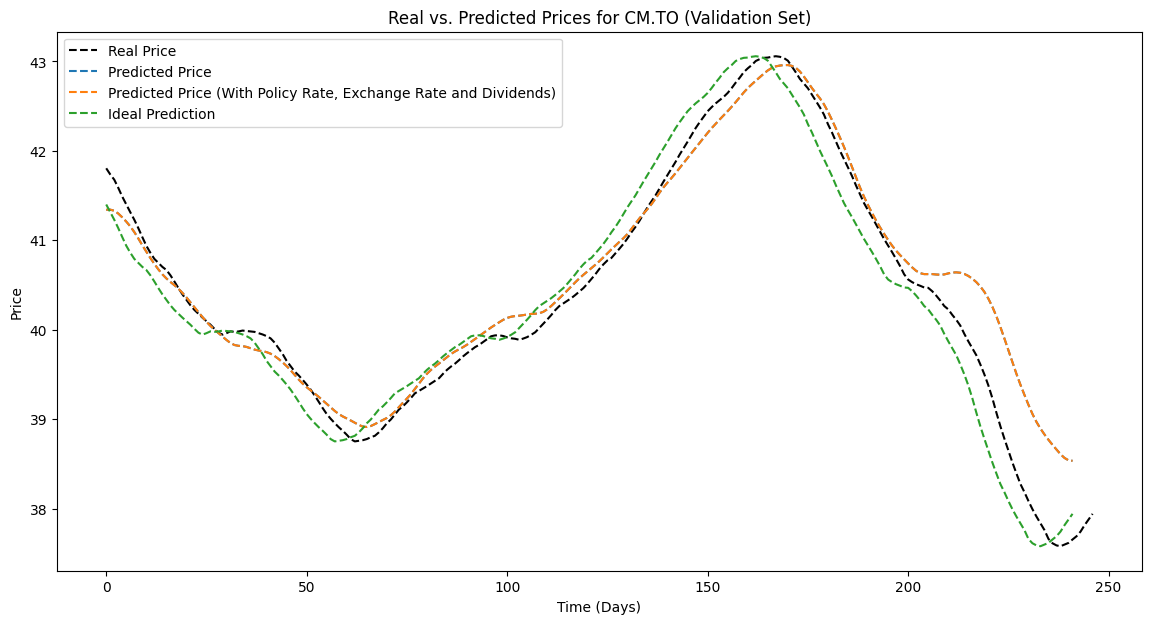

In [19]:
# Plot the results for the validation portion
plt.figure(figsize=(14, 7))

# Plot the real prices directly
plt.plot(real_prices_data_validation, label='Real Price', color='black', linestyle='--')

# Plot predicted prices for each prediction day in the range of PREDICTION_DAYS_AHEAD

plt.plot(predicted_prices, label='Predicted Price ', linestyle='--')
plt.plot(predicted_prices_dividend, label='Predicted Price (With Policy Rate, Exchange Rate and Dividends)', linestyle='--')
plt.plot(real_prices, label='Ideal Prediction',linestyle='--')

plt.title(f"Real vs. Predicted Prices for {STOCK_FOR_VALIDATION} (Validation Set)")
plt.xlabel("Time (Days)")
plt.ylabel("Price")
plt.legend()
plt.show()

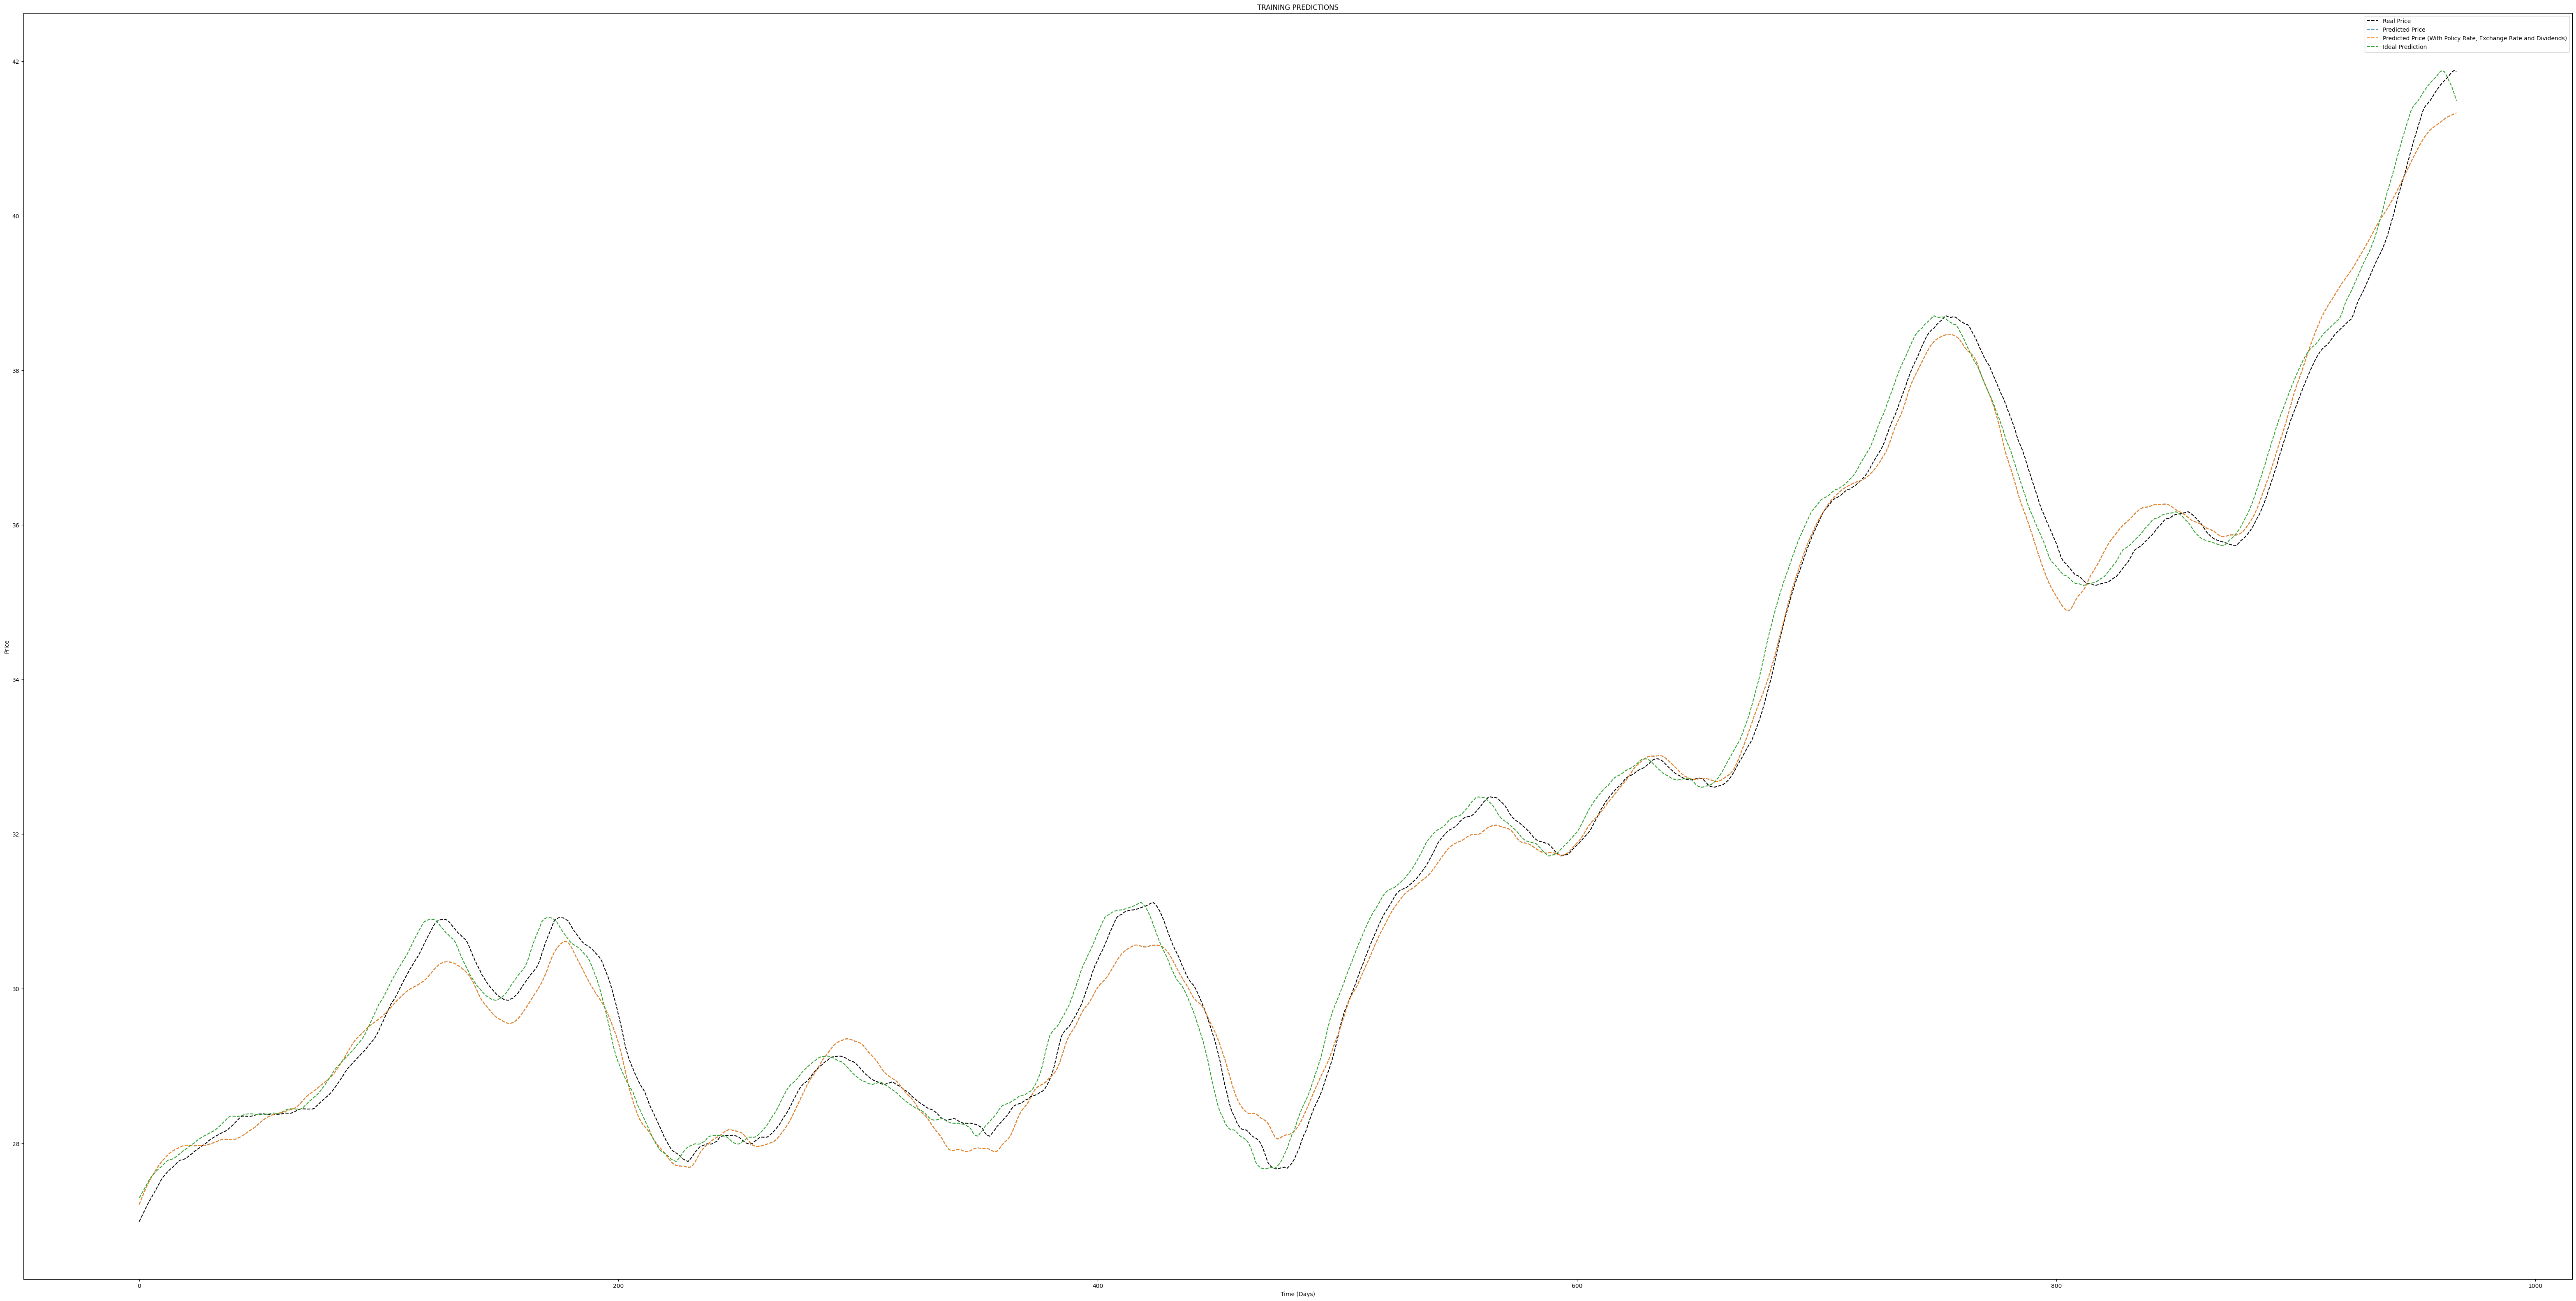

In [20]:
# Plot the results for the validation portion
plt.figure(figsize=(80, 40))

# Plot the real prices directly
plt.plot(real_prices_data_training, label='Real Price', color='black', linestyle='--')

# Plot predicted prices for each prediction day in the range of PREDICTION_DAYS_AHEAD

plt.plot(train_predicted_prices, label='Predicted Price', linestyle='--')
plt.plot(train_predicted_prices_dividend, label='Predicted Price (With Policy Rate, Exchange Rate and Dividends)', linestyle='--')
plt.plot(train_real_prices, label='Ideal Prediction',linestyle='--')

plt.title(f"TRAINING PREDICTIONS")
plt.xlabel("Time (Days)")
plt.ylabel("Price")
plt.legend()
#plt.xlim(2200, 2250)
plt.show()